# Importações

In [1]:
import os
import cv2
import sklearn
import numpy as np
import shapely
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from shapely.geometry.polygon import Polygon
from shapely.ops import unary_union
from shapely.validation import explain_validity
import pickle
import warnings
warnings.filterwarnings('ignore')

# Organizando e Visualizando as Imagens

In [2]:
path_data_train = 'dados/dados/EuroSAT/2750/Training/'
path_data_test = 'dados/dados/EuroSAT/2750/Test/'

In [3]:
class_names = [name for name in os.listdir(path_data_train) if name != '.DS_Store']
print(f'Classes: \n{class_names}')

Classes: 
['River', 'Forest', 'Residential', 'SeaLake', 'HerbaceousVegetation', 'Highway', 'Pasture', 'AnnualCrop', 'PermanentCrop', 'Industrial']


In [4]:
image_collection = [np.random.choice(os.listdir(path_data_train + '/' + class_)) for class_ in class_names]
image_collection

['River_2161.jpg',
 'Forest_1952.jpg',
 'Residential_208.jpg',
 'SeaLake_2130.jpg',
 'HerbaceousVegetation_1709.jpg',
 'Highway_2404.jpg',
 'Pasture_703.jpg',
 'AnnualCrop_76.jpg',
 'PermanentCrop_2277.jpg',
 'Industrial_1859.jpg']

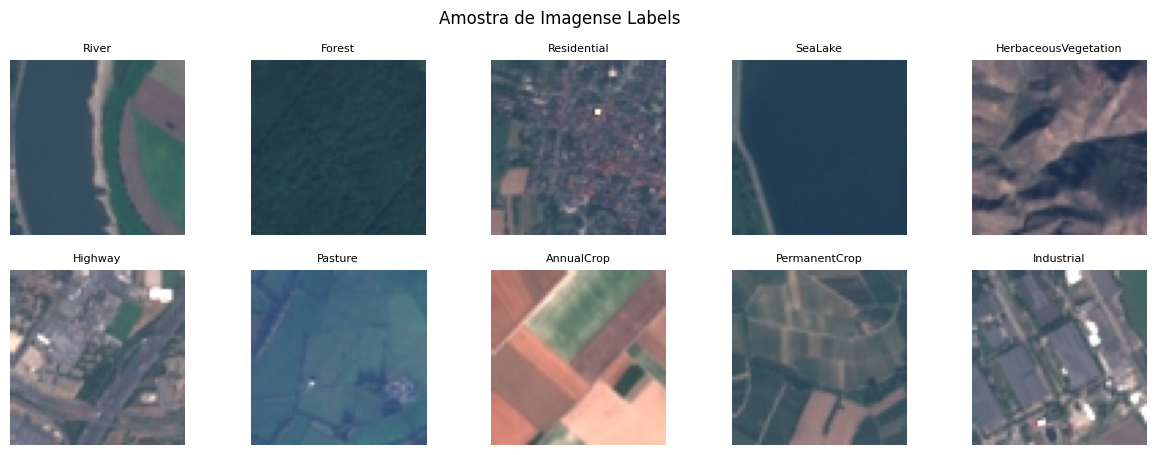

In [5]:
nrow, ncol = 2, 5

_, ax = plt.subplots(nrow, ncol, figsize=(15, 5))
plt.suptitle('Amostra de Imagense Labels')
for i, images, label in zip(range(10), image_collection, class_names):
    ax[i//ncol, i%ncol].imshow(plt.imread(path_data_train + '/' + label + '/' + images))
    ax[i//ncol, i%ncol].set_title(f'{label}', fontsize = 8)
    ax[i//ncol, i%ncol].axis('off')

plt.show()

# Segmentação de Imagens - Método 1 - Scikit-learn K-Means

In [6]:
path_image = f'{path_data_train}/AnnualCrop/AnnualCrop_10.jpg'
path_image

'dados/dados/EuroSAT/2750/Training//AnnualCrop/AnnualCrop_10.jpg'

In [7]:
def clusteriza_imagem_kmeans(image, n_clusters):
    img = image.reshape((-1, 1))
    cluster = KMeans(n_clusters = n_clusters, n_init = 4)
    cluster.fit(img)
    centroids = cluster.cluster_centers_.squeeze()
    labels = cluster.labels_
    return centroids, labels

In [8]:
def segmenta_Imagem_kmeans(filepath, n_clusters):
    img = plt.imread(filepath)
    centroids, labels = clusteriza_imagem_kmeans(img, n_clusters)
    segmented_img = np.choose(labels, centroids).astype(np.uint8).reshape(img.shape)
    return img, segmented_img

In [9]:
sk_img, sk_segmented_image_k3 = segmenta_Imagem_kmeans(path_image, 3)
sk_img, sk_segmented_image_k4 = segmenta_Imagem_kmeans(path_image, 4)

In [10]:
def plot_segmento(image, segmented_image, title = None):
    fig, ax = plt.subplots(1, 5, figsize=(19, 3))

    ax[0].imshow(image)
    ax[0].set_title('Imagem Original')
    ax[0].axis('off')

    ax[1].imshow(segmented_image, cmap = 'viridis')
    ax[1].set_title('Imagem Segmentada')
    ax[1].axis('off')

    for i in range(3):
        ax[i+2].set_title(f'Caanal: {'RGB'[i]}')
        ims = ax[i+2].imshow(segmented_image[:,:,i])
        ax[i+2].axis('off')

    p0 = ax[2].get_position().get_points().flatten()
    p1 = ax[3].get_position().get_points().flatten()
    p2 = ax[4].get_position().get_points().flatten()
    ax_cbar = fig.add_axes([p0[0], 0, p2[2] - p0[0], 0.05])
    plt.colorbar(ims, cax = ax_cbar, orientation = 'horizontal')

    if title:
        plt.suptitle(title, size = 14, y = 1.1)

    plt.show()

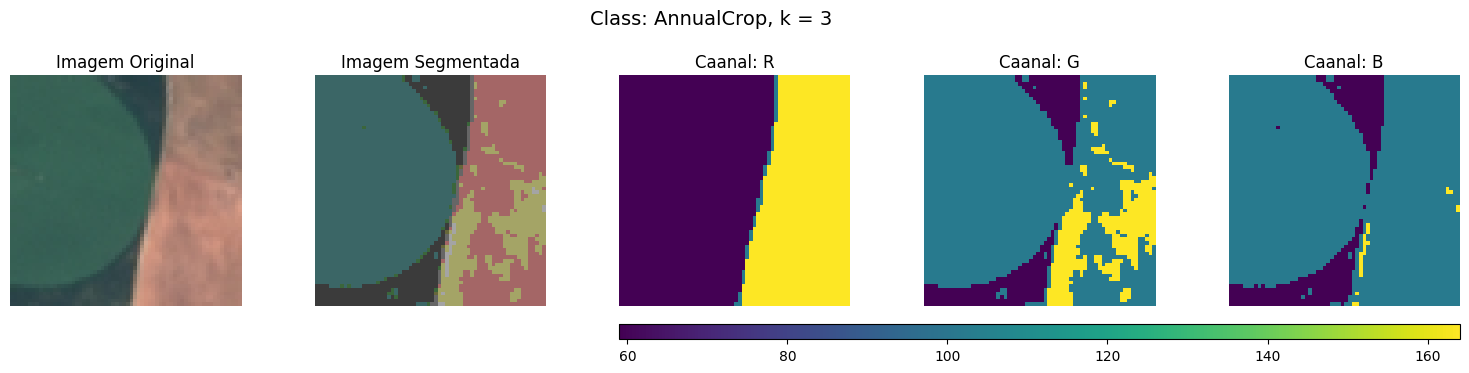

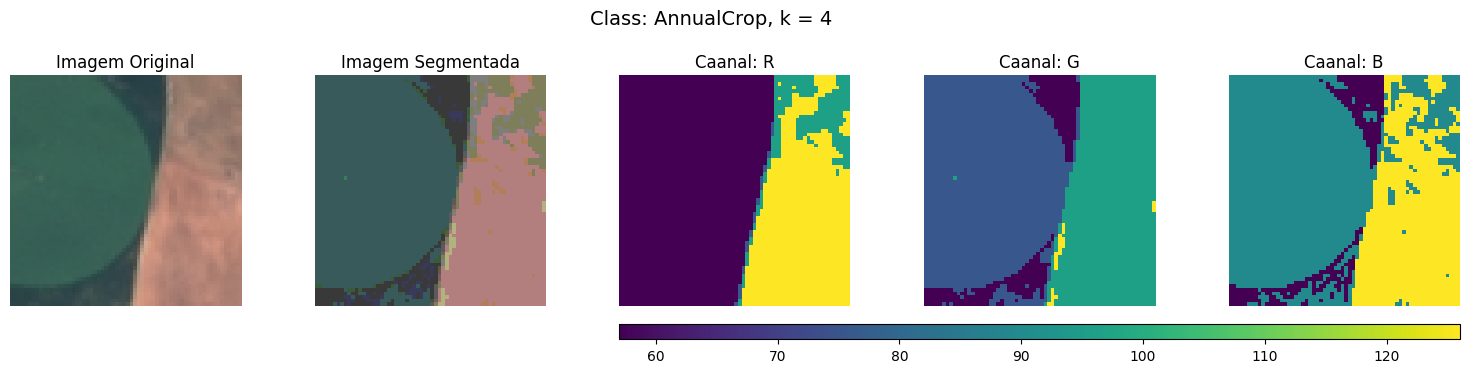

In [11]:
plot_segmento(sk_img, sk_segmented_image_k3, 'Class: AnnualCrop, k = 3')
plot_segmento(sk_img, sk_segmented_image_k4, 'Class: AnnualCrop, k = 4')

# Segmentação de Imagens - Método 2 - OpenCV K-Means

In [12]:
image_size = (64, 64)

In [13]:
path_image = f'{path_data_train}/AnnualCrop/AnnualCrop_10.jpg'

In [14]:
def salva_modelo(centroids, filename):

    with open(filename, 'wb') as file:
        pickle.dump(centroids, file)

In [15]:
def clusterizacao_imagem_kmeans_cv2(image,
                                    n_clusters,
                                    eps,
                                    max_iter = 10,
                                    attempts = 10,
                                    save_model = False,
                                    model_filename = None):
    image_size = image.shape
    img = image.reshape((-1, 3)).astype('float32')
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    _, labels, centroids = cv2.kmeans(img, n_clusters, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)

    centroids = np.uint8(centroids)

    segmented_data = centroids[labels.flatten()]
    segmented_image = segmented_data.reshape(image_size)

    if save_model and model_filename:
        salva_modelo(centroids, model_filename)

    return segmented_image

In [16]:
def segmenta_imagem_kmeans_cv2(filepath, n_clusters, eps):
    img = plt.imread(filepath)

    segmented_img = clusterizacao_imagem_kmeans_cv2(img,
                                                    n_clusters,
                                                    eps,
                                                    save_model= True,
                                                    model_filename= model_filename)

    return img, segmented_img

In [17]:
model_filename = 'modelo/kmeans_model.pkl'

In [18]:
cv_img, cv_segmented_image_k3 = segmenta_imagem_kmeans_cv2(path_image, 3, 0.7)
cv_img, cv_segmented_image_k4 = segmenta_imagem_kmeans_cv2(path_image, 4, 0.7)

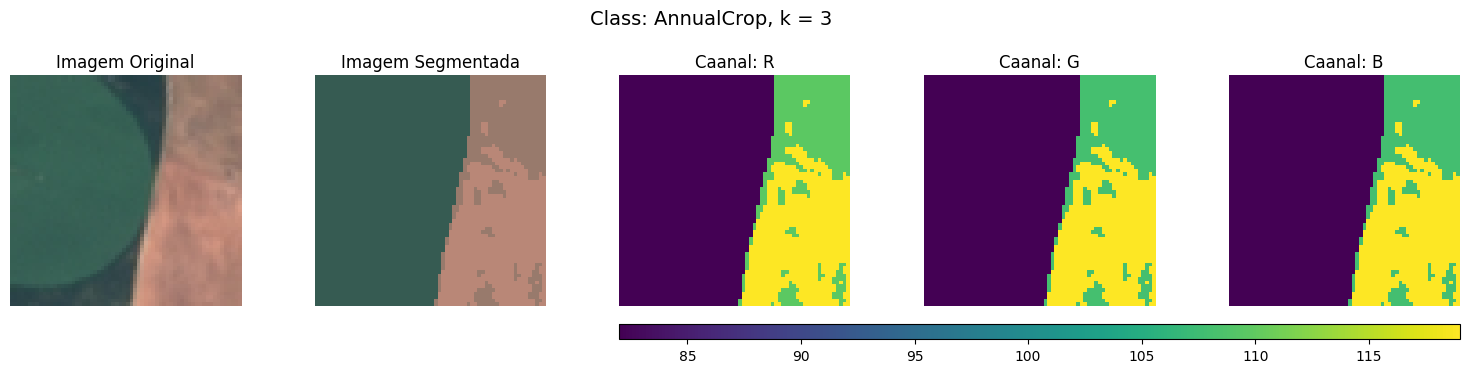

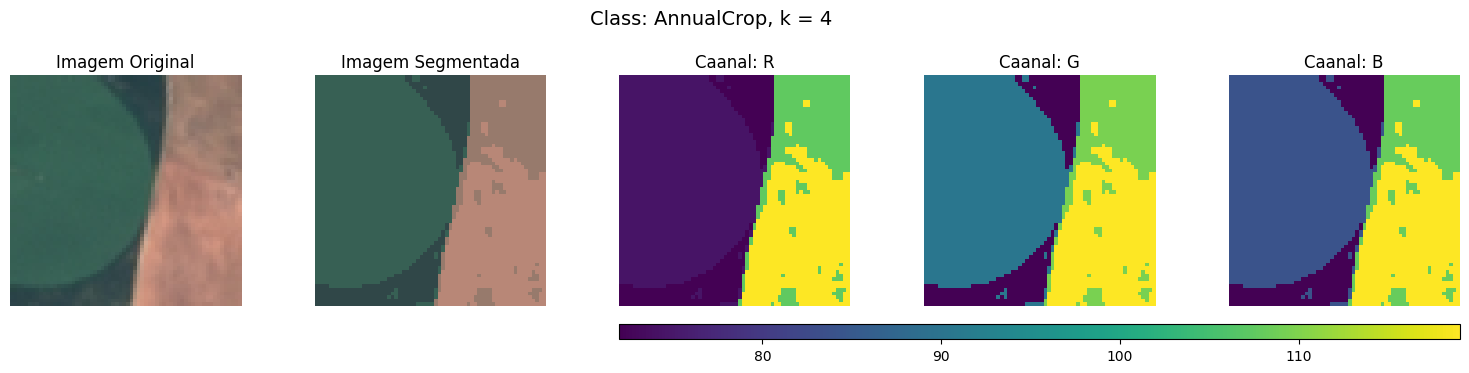

In [19]:
plot_segmento(cv_img, cv_segmented_image_k3, 'Class: AnnualCrop, k = 3')
plot_segmento(cv_img, cv_segmented_image_k4, 'Class: AnnualCrop, k = 4')

# Estimação do Contorno

In [20]:
def draw_contour(image, thresh, t_method = 'binary'):

    image_size = image.shape
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    method = {
        'binary': cv2.THRESH_BINARY,
        'binary_inv': cv2.THRESH_BINARY_INV,
        'trunc': cv2.THRESH_TRUNC,
        'trozero': cv2.THRESH_TOZERO,
        'trozero_inv': cv2.THRESH_TOZERO_INV
    }

    _, thresh_img = cv2.threshold(gray_img, thresh, 255, method[t_method])
    contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = np.zeros(image_size)
    contours_img = cv2.drawContours(img_contours, contours, -1, (102, 204, 0), 1)

    return contours_img, contours

In [21]:
def plot_contorno(image, segmented_image, bin_image, contour, title = None):

    fig, ax = plt.subplots(1, 4, figsize=(16.5, 3))

    ax[0].imshow(image)
    ax[0].set_title('Imagem Original')
    ax[0].axis('off')

    ax[1].imshow(segmented_image)
    ax[1].set_title('Imagem Segmentada')
    ax[1].axis('off')

    ims = ax[2].imshow(bin_image, cmap = 'binary')
    ax[2].set_title('Imagem Monocromática')
    ax[2].axis('off')
    plt.colorbar(ims, ax=ax[2], fraction=0.045)

    ax[3].imshow(contour.astype(np.uint8))
    ax[3].set_title('Contorno da Imagem Segmentada')
    ax[3].axis('off')

    if title:
        plt.suptitle(title, size = 14, y = 1.1)

    plt.show()

In [22]:
def polygon_from_contour(contour):
    List_polygons = []

    for cont in contour:
        try:
            polygon = Polygon(cont.reshape(-1, 2))

            if not polygon.is_valid:
                print(f'Polígono Interseção: {explain_validity(polygon)}')
                polygon = polygon.buffer(0)

            List_polygons.append(polygon)
        except ValueError:
            continue

    return unary_union(List_polygons)

In [23]:
def compute_area(contours, return_pct = False, image_size= None):
    contour = polygon_from_contour(contours)

    if return_pct:
        x, y, _ = image_size if len(image_size) == 3 else image_size + (None,)
        frame = Polygon([(0, 0), (0, y), (x, y), (x, 0)])

        return np.round(100 * contour.area / frame.area, 4)

    return np.round(contour.area, 4)

## Detectando os Contornos no Método 1 - Scikit-learn K-Means

In [24]:
sk_img_grey_k3 = cv2.cvtColor(sk_segmented_image_k3, cv2.COLOR_BGR2GRAY)
sk_img_grey_k4 = cv2.cvtColor(sk_segmented_image_k4, cv2.COLOR_BGR2GRAY)

In [25]:
sk_thresh_k3 = np.quantile(sk_img_grey_k3, 0.5)
sk_thresh_k3_ = np.quantile(sk_img_grey_k3, 0.61)
sk_thresh_k4 = np.quantile(sk_img_grey_k4, 0.5)

In [26]:
sk_contour_k3, sk_cont_k3 = draw_contour(sk_segmented_image_k3, sk_thresh_k3, 'binary')
sk_contour_k3_, sk_cont_k3_ = draw_contour(sk_segmented_image_k3, sk_thresh_k3_, 'binary')
sk_contour_k4, sk_cont_k4 = draw_contour(sk_segmented_image_k4, sk_thresh_k4, 'binary')

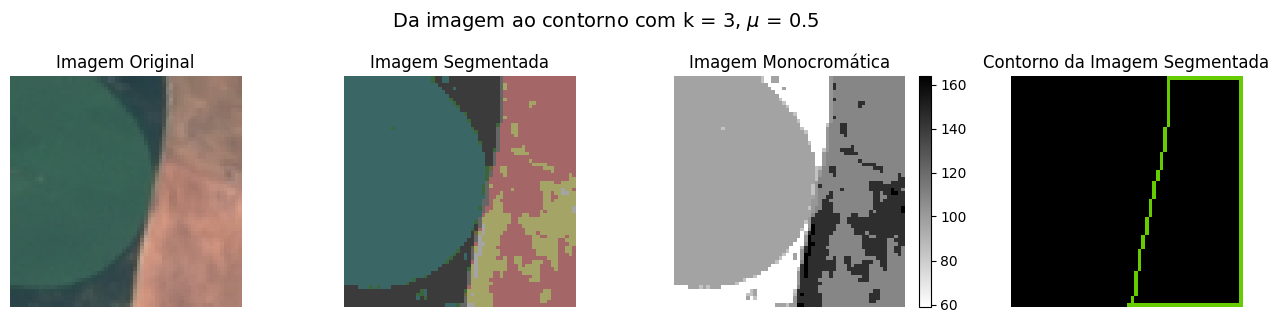

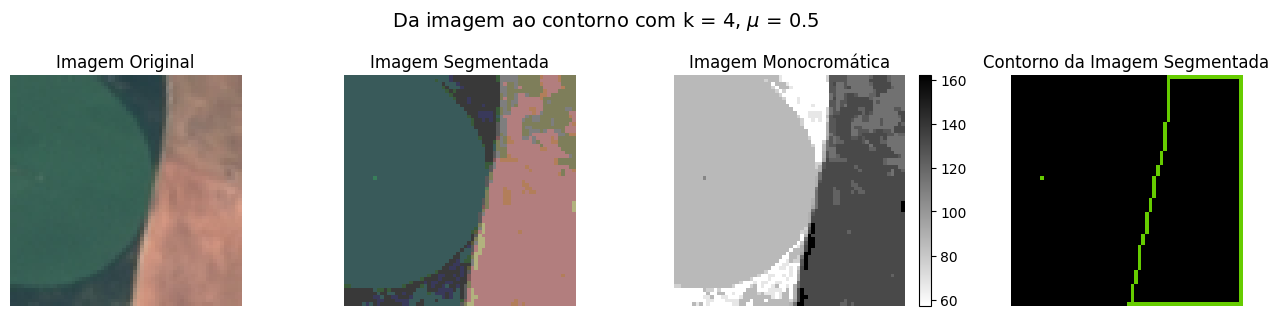

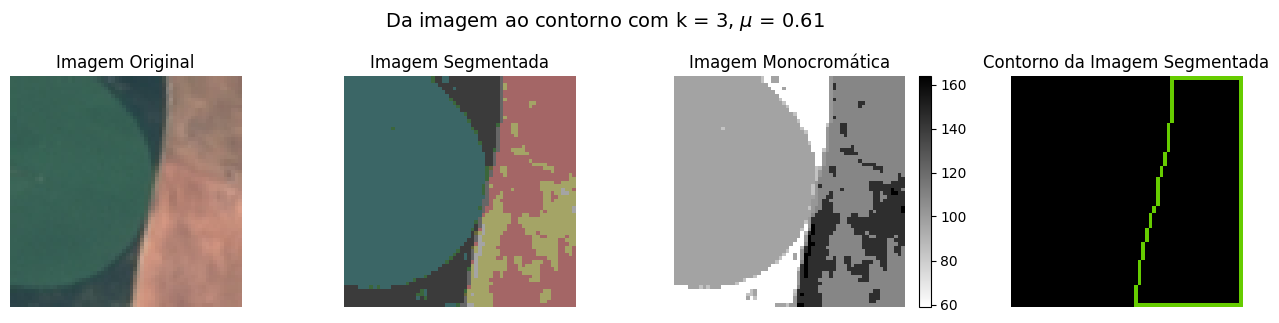

In [27]:
plot_contorno(
    sk_img,
    sk_segmented_image_k3,
    sk_img_grey_k3,
    sk_contour_k3,
    'Da imagem ao contorno com k = 3, $\mu$ = 0.5'
)
plot_contorno(
    sk_img,
    sk_segmented_image_k4,
    sk_img_grey_k4,
    sk_contour_k4,
    'Da imagem ao contorno com k = 4, $\mu$ = 0.5'
)
plot_contorno(
    sk_img,
    sk_segmented_image_k3,
    sk_img_grey_k3,
    sk_contour_k3_,
    'Da imagem ao contorno com k = 3, $\mu$ = 0.61'
)

In [28]:
print(f'{compute_area(contours=sk_cont_k3, return_pct = True, image_size = sk_contour_k3.shape):.2f}% de área não usada para segmentação.')
print(f'{compute_area(contours=sk_cont_k4, return_pct = True, image_size = sk_contour_k4.shape):.2f}% de área não usada para segmentação.')
print(f'{compute_area(contours=sk_cont_k3_, return_pct = True, image_size = sk_contour_k3_.shape):.2f}% de área não usada para segmentação.')

37.24% de área não usada para segmentação.
37.44% de área não usada para segmentação.
35.99% de área não usada para segmentação.


## Detectando os Contornos no Método 2 - OpenCV K-Means

In [29]:
cv_img_grey_k3 = cv2.cvtColor(cv_segmented_image_k3, cv2.COLOR_BGR2GRAY)
cv_img_grey_k4 = cv2.cvtColor(cv_segmented_image_k4, cv2.COLOR_BGR2GRAY)

In [30]:
cv_thresh_k3 = np.quantile(cv_img_grey_k3, 0.5)
cv_thresh_k3_ = np.quantile(cv_img_grey_k3, 0.61)
cv_thresh_k4 = np.quantile(cv_img_grey_k4, 0.5)

In [31]:
cv_contour_k3, cv_cont_k3 = draw_contour(cv_segmented_image_k3, cv_thresh_k3, 'binary')
cv_contour_k3_, cv_cont_k3_ = draw_contour(cv_segmented_image_k3, cv_thresh_k3_, 'binary')
cv_contour_k4, cv_cont_k4 = draw_contour(cv_segmented_image_k4, cv_thresh_k4, 'binary')

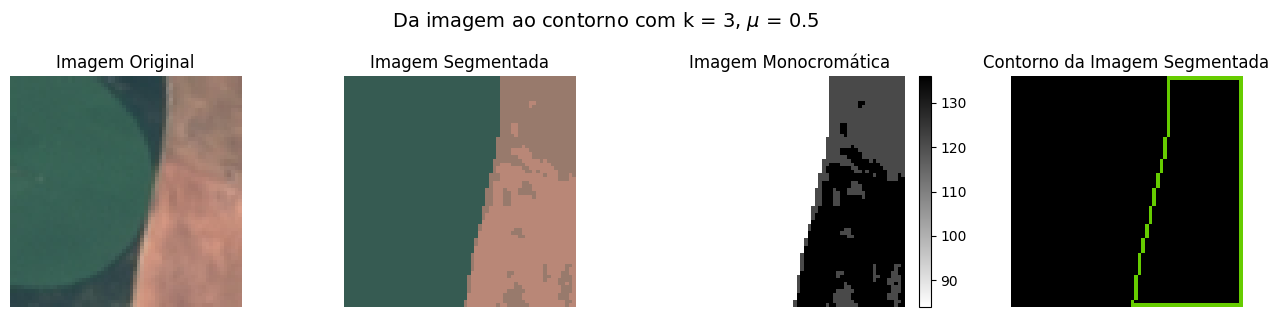

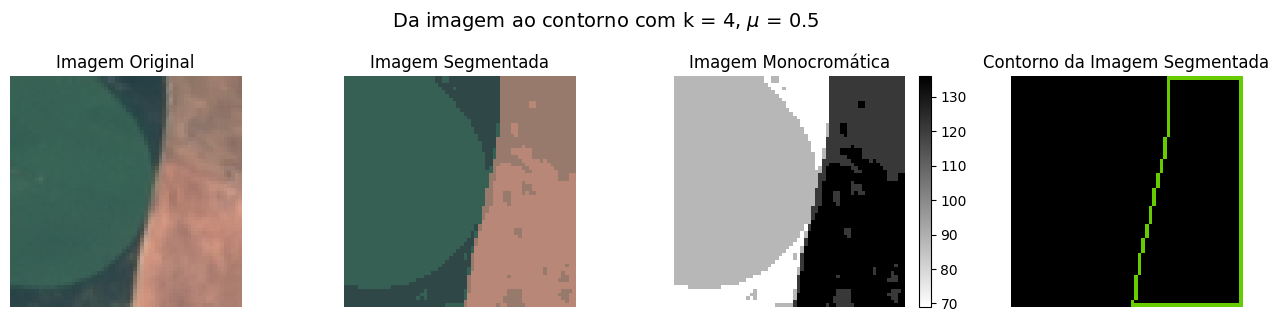

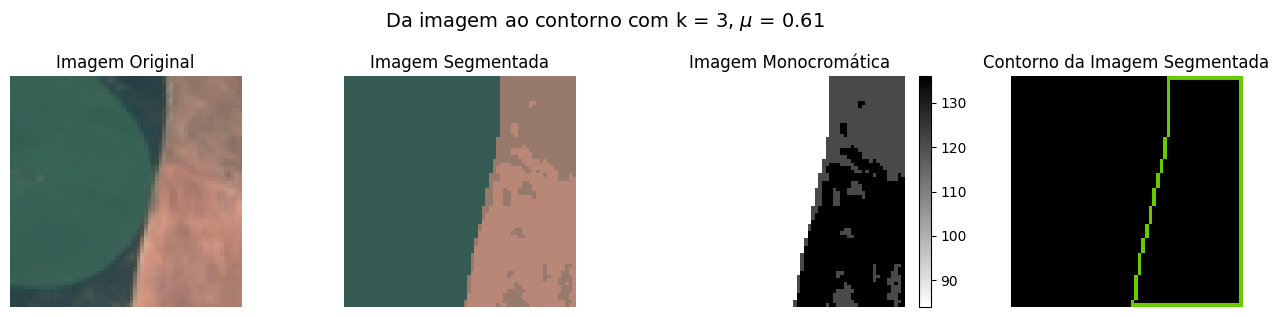

In [32]:
plot_contorno(
    cv_img,
    cv_segmented_image_k3,
    cv_img_grey_k3,
    cv_contour_k3,
    'Da imagem ao contorno com k = 3, $\mu$ = 0.5'
)
plot_contorno(
    cv_img,
    cv_segmented_image_k4,
    cv_img_grey_k4,
    cv_contour_k4,
    'Da imagem ao contorno com k = 4, $\mu$ = 0.5'
)
plot_contorno(
    cv_img,
    cv_segmented_image_k3,
    cv_img_grey_k3,
    cv_contour_k3_,
    'Da imagem ao contorno com k = 3, $\mu$ = 0.61'
)

In [33]:
print(f'{compute_area(contours=cv_cont_k3, return_pct = True, image_size = cv_contour_k3.shape):.2f}% de área não usada para segmentação.')
print(f'{compute_area(contours=cv_cont_k4, return_pct = True, image_size = cv_contour_k4.shape):.2f}% de área não usada para segmentação.')
print(f'{compute_area(contours=cv_cont_k3_, return_pct = True, image_size = cv_contour_k3_.shape):.2f}% de área não usada para segmentação.')

36.84% de área não usada para segmentação.
36.84% de área não usada para segmentação.
36.84% de área não usada para segmentação.


# Testando e Avaliando a Segmentação Não Supervisionada

In [37]:
def processa_segmentation(filepath,
                          n_clusters,
                          km_method = 'opencv',
                          eps = 0.7,
                          thresh = 0.5,
                          t_method = 'binary',
                          title = None):
    if km_method == 'sklearn':
        img, segmented_img = segmenta_Imagem_kmeans(filepath, n_clusters)
    elif km_method == 'opencv':
        img, segmented_img = segmenta_imagem_kmeans_cv2(filepath, n_clusters, eps)
    else:
        raise ValueError('Método não reconhecido: use "sklearn" ou "opencv"')

    img_grey = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)
    thresh_val = np.quantile(img_grey, thresh)
    contour, cont_ = draw_contour(segmented_img, thresh_val, t_method)
    plot_contorno(img, segmented_img, img_grey, contour, title)

    spacing = 4 * '\t ' + '     '
    print(f'\n{spacing} {compute_area(cont_, return_pct = True, image_size= contour.shape):.1f}% de área não usada para segmentação.')

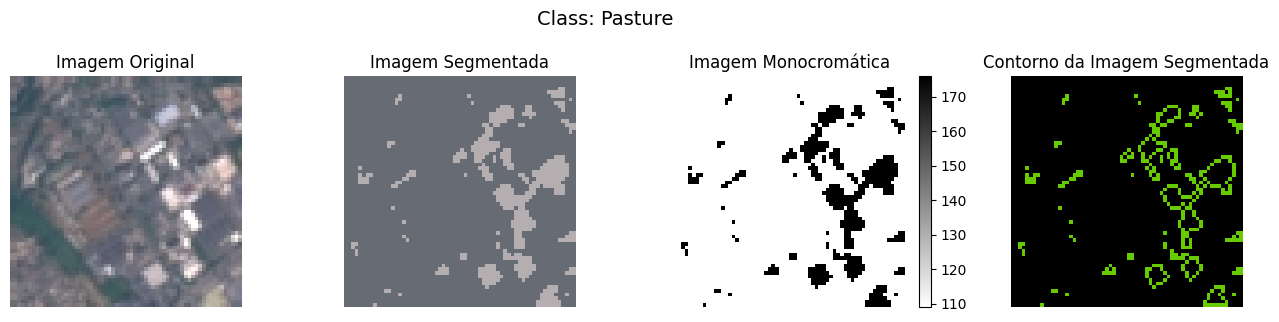

Polígono Interseção: Ring Self-intersection[46 50]
Polígono Interseção: Ring Self-intersection[2 47]
Polígono Interseção: Self-intersection[60 45]
Polígono Interseção: Ring Self-intersection[16 28]
Polígono Interseção: Ring Self-intersection[51 30]
Polígono Interseção: Ring Self-intersection[37 23]

	 	 	 	       7.3% de área não usada para segmentação.


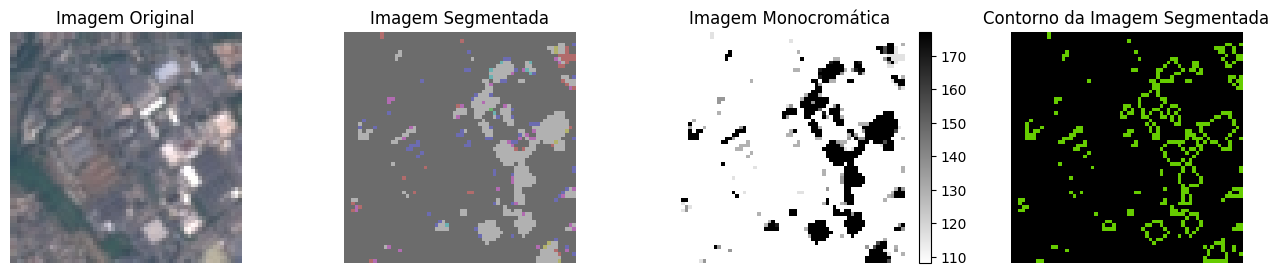

Polígono Interseção: Ring Self-intersection[54 60]
Polígono Interseção: Ring Self-intersection[46 50]
Polígono Interseção: Ring Self-intersection[2 47]
Polígono Interseção: Ring Self-intersection[59 45]
Polígono Interseção: Ring Self-intersection[19 31]
Polígono Interseção: Ring Self-intersection[15 29]
Polígono Interseção: Self-intersection[4 25]
Polígono Interseção: Ring Self-intersection[43 22]

	 	 	 	       8.9% de área não usada para segmentação.


In [38]:
idx = 6
filepath = 'dados/dados/EuroSAT/2750/Training/Industrial/Industrial_1145.jpg'
title = f'Class: {class_names[idx]}'
processa_segmentation(filepath, 2, km_method= 'opencv', thresh= .1, t_method = 'binary', title = title)
processa_segmentation(filepath, 2, km_method= 'sklearn', thresh= .1, t_method = 'binary')

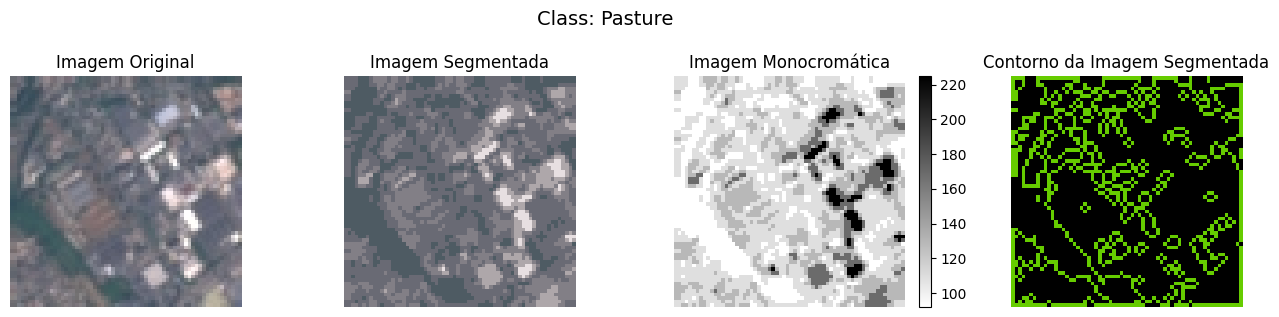

Polígono Interseção: Ring Self-intersection[2 14]
Polígono Interseção: Self-intersection[49 0]

	 	 	 	       79.6% de área não usada para segmentação.


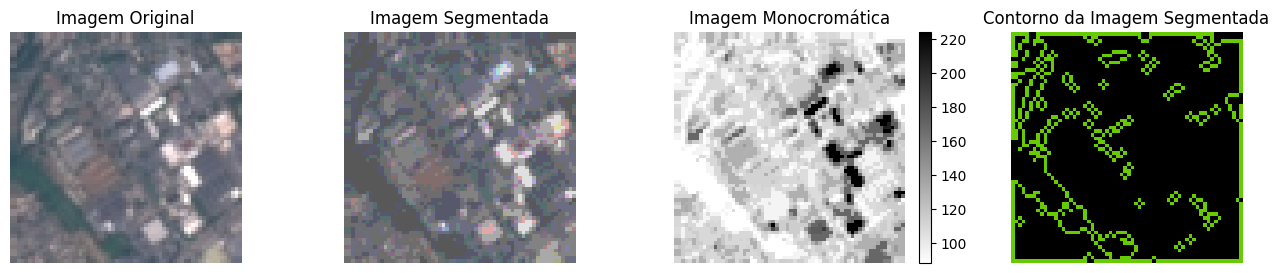

Polígono Interseção: Self-intersection[4 6]
Polígono Interseção: Self-intersection[63 20]
Polígono Interseção: Ring Self-intersection[15 48]

	 	 	 	       89.9% de área não usada para segmentação.


In [39]:
idx = 6
filepath = 'dados/dados/EuroSAT/2750/Training/Industrial/Industrial_1145.jpg'
title = f'Class: {class_names[idx]}'
processa_segmentation(filepath, 5, km_method= 'opencv', thresh= .1, t_method = 'binary', title = title)
processa_segmentation(filepath, 5, km_method= 'sklearn', thresh= .1, t_method = 'binary')

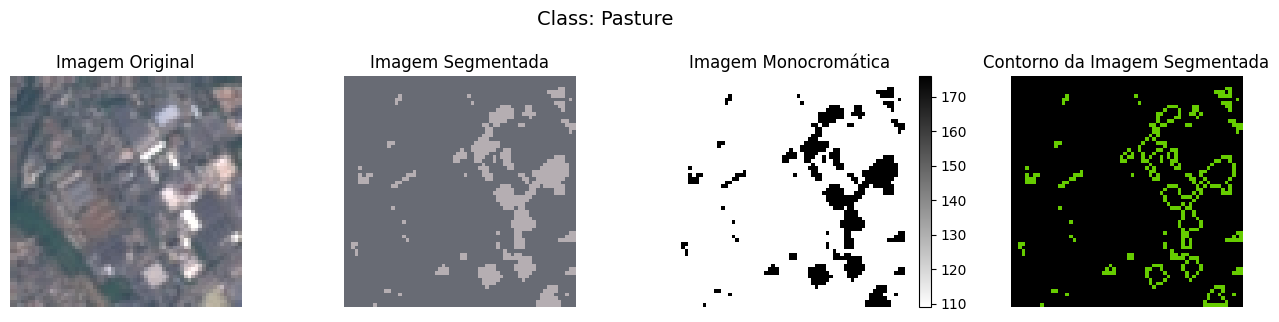

Polígono Interseção: Ring Self-intersection[46 50]
Polígono Interseção: Ring Self-intersection[2 47]
Polígono Interseção: Self-intersection[60 45]
Polígono Interseção: Ring Self-intersection[18 27]
Polígono Interseção: Ring Self-intersection[51 30]
Polígono Interseção: Ring Self-intersection[37 23]

	 	 	 	       7.3% de área não usada para segmentação.


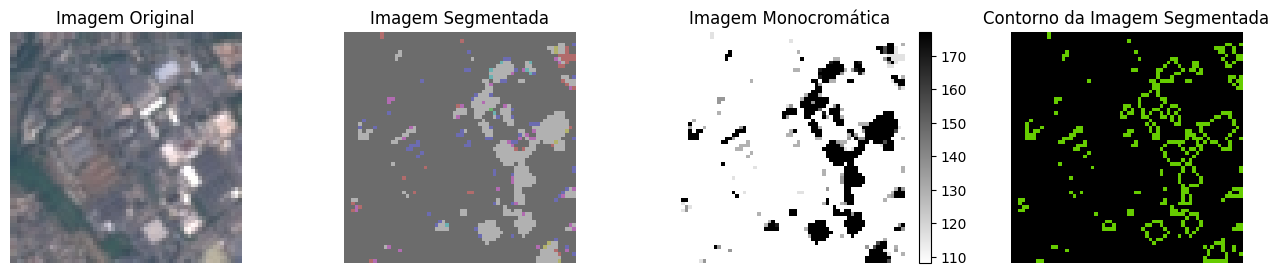

Polígono Interseção: Ring Self-intersection[54 60]
Polígono Interseção: Ring Self-intersection[46 50]
Polígono Interseção: Ring Self-intersection[2 47]
Polígono Interseção: Ring Self-intersection[59 45]
Polígono Interseção: Ring Self-intersection[19 31]
Polígono Interseção: Ring Self-intersection[15 29]
Polígono Interseção: Self-intersection[4 25]
Polígono Interseção: Ring Self-intersection[43 22]

	 	 	 	       8.9% de área não usada para segmentação.


In [43]:
idx = 6
filepath = "dados/dados/EuroSAT/2750/Training/Industrial/Industrial_1145.jpg"
title = "Class: {}".format(class_names[idx])
processa_segmentation(filepath, 2, km_method = 'opencv', thresh = .7, t_method = 'binary', title = title)
processa_segmentation(filepath, 2, km_method = 'sklearn', thresh = .7, t_method = 'binary')

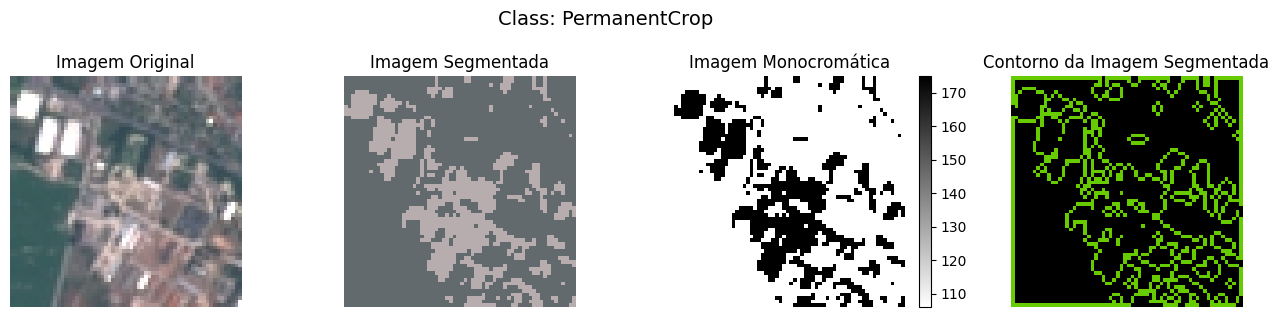

Polígono Interseção: Ring Self-intersection[49 60]
Polígono Interseção: Ring Self-intersection[24 45]
Polígono Interseção: Self-intersection[29 45]
Polígono Interseção: Self-intersection[30 37]
Polígono Interseção: Ring Self-intersection[14 13]

	 	 	 	       91.0% de área não usada para segmentação.


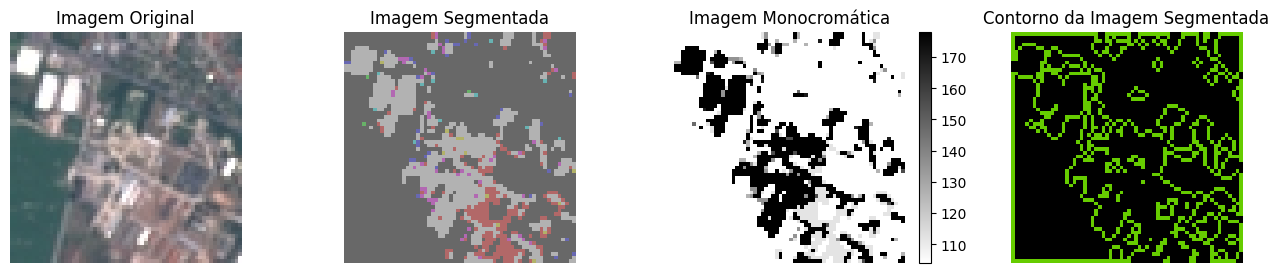

Polígono Interseção: Self-intersection[29 45]
Polígono Interseção: Self-intersection[30 37]
Polígono Interseção: Ring Self-intersection[23 32]
Polígono Interseção: Ring Self-intersection[14 13]

	 	 	 	       71.6% de área não usada para segmentação.


In [44]:
idx = 8
filepath = "dados/dados/EuroSAT/2750/Training/Industrial/Industrial_1313.jpg"
title = "Class: {}".format(class_names[idx])
processa_segmentation(filepath, 2, km_method = 'opencv', thresh = .1, t_method = 'trozero_inv', title = title)
processa_segmentation(filepath, 2, km_method = 'sklearn', thresh = .1, t_method = 'trozero_inv')

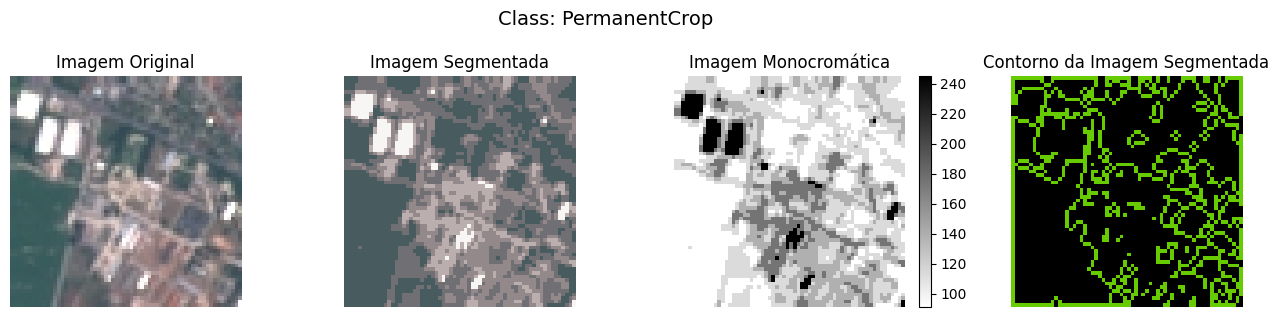

Polígono Interseção: Self-intersection[44 61]
Polígono Interseção: Self-intersection[26 42]
Polígono Interseção: Ring Self-intersection[33 35]
Polígono Interseção: Ring Self-intersection[57 7]

	 	 	 	       58.7% de área não usada para segmentação.


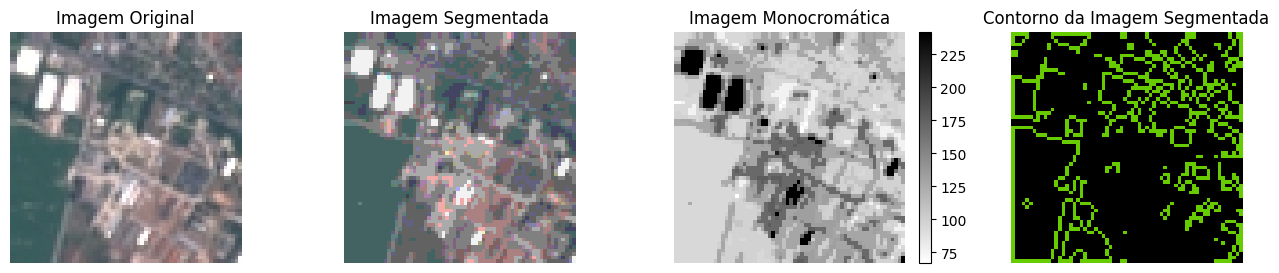

Polígono Interseção: Self-intersection[59 63]
Polígono Interseção: Self-intersection[43 48]
Polígono Interseção: Self-intersection[57 39]
Polígono Interseção: Ring Self-intersection[49 41]
Polígono Interseção: Ring Self-intersection[28 36]
Polígono Interseção: Ring Self-intersection[10 10]
Polígono Interseção: Ring Self-intersection[61 2]
Polígono Interseção: Ring Self-intersection[52 7]
Polígono Interseção: Ring Self-intersection[37 1]

	 	 	 	       35.2% de área não usada para segmentação.


In [45]:
idx = 8
filepath = "dados/dados/EuroSAT/2750/Training/Industrial/Industrial_1313.jpg"
title = "Class: {}".format(class_names[idx])
processa_segmentation(filepath, 5, km_method = 'opencv', thresh = .35, t_method = 'trozero_inv', title = title)
processa_segmentation(filepath, 5, km_method = 'sklearn', thresh = .35, t_method = 'trozero_inv')